In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import Caltech101
from torchvision.models import vgg16
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.4 MB/s eta 0:00:00


In [4]:
# Uncompress the dataset
!unzip -uq "drive/MyDrive/Objects.zip" -d "sample_data/"

In [5]:
import os
dataset_path = 'sample_data/Objects'  # Adjust if needed
print(os.listdir(dataset_path))  # This should print class folders if unzipped correctly


['crayfish', 'panda', 'Faces_easy', 'flamingo', 'mandolin', 'sunflower', 'pigeon', 'emu', 'euphonium', 'brontosaurus', 'umbrella', 'revolver', 'headphone', 'snoopy', 'dragonfly', 'binocular', 'anchor', 'chair', 'mayfly', 'Motorbikes', 'llama', 'wild_cat', 'starfish', 'lotus', 'ferry', 'trilobite', 'bass', 'electric_guitar', 'hedgehog', 'bonsai', 'crocodile', 'metronome', 'accordion', 'cannon', 'beaver', 'buddha', 'pagoda', 'platypus', 'nautilus', 'cougar_body', 'ewer', 'dolphin', 'wrench', 'cup', 'scissors', 'strawberry', 'cellphone', 'yin_yang', 'hawksbill', 'gerenuk', 'pizza', 'barrel', 'water_lilly', 'Faces', 'ketch', 'lamp', 'crab', 'saxophone', 'kangaroo', 'laptop', 'cougar_face', 'helicopter', 'gramophone', 'tick', 'garfield', 'camera', 'stop_sign', 'Leopards', 'okapi', 'rhino', 'stapler', 'minaret', 'car_side', 'octopus', 'stegosaurus', 'dollar_bill', 'flamingo_head', 'butterfly', 'lobster', 'menorah', 'rooster', 'watch', 'grand_piano', 'joshua_tree', 'ibis', 'airplanes', 'winds

In [6]:
# Import FGMS and PGD attacks
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [7]:
# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((128, 128)),# Resize the images to 128 x 128 pixels
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert the images to a PyTorch tensor
])

# Download the entire dataset (without the split argument)
dataset = Caltech101(root='sample_data/Objects', transform=transform, download=True)

# Calculate the sizes for train, validation, and test splits (e.g., 80% train, 10% validation, 10% test)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))  # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Now you can print the datasets to check them
print(train_dataset)
print(test_dataset)
print(val_dataset)  # Print the validation dataset instead of 'validation_dataset'
# Print the sizes of the datasets in a human-readable format
print(f"\nTraining dataset contains {len(train_dataset)} images.")
print(f"Validation dataset contains {len(val_dataset)} images.")
print(f"Test dataset contains {len(test_dataset)} images.\n")



Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=0cfd0a59-0f87-4f75-87d2-de3102097ad7
To: /content/sample_data/Objects/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 109MB/s]


Extracting sample_data/Objects/caltech101/101_ObjectCategories.tar.gz to sample_data/Objects/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/sample_data/Objects/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 117MB/s]


Extracting sample_data/Objects/caltech101/Annotations.tar to sample_data/Objects/caltech101

Training dataset contains 6941 images.
Validation dataset contains 867 images.
Test dataset contains 869 images.



In [8]:
# Create dataloaders to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [9]:
# Asscociate the names of Objects
Object_names = ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler', 'starfish', 'stegosaurus', 'stop_sign', 'strawberry', 'sunflower', 'tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']

In [10]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

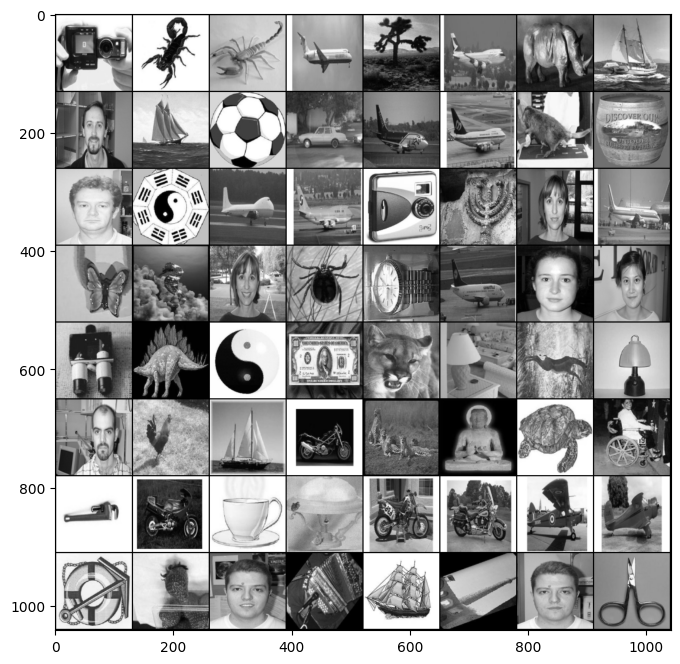

In [11]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

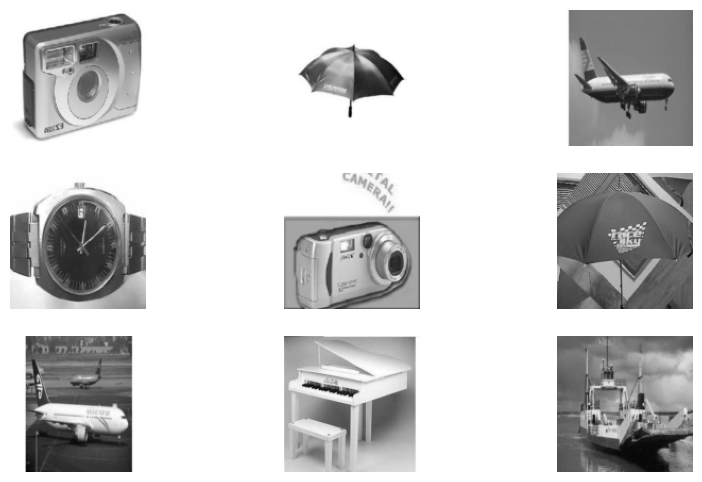

In [12]:
# Plot several images without labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, _ = next(data)  # Ignore labels
    img = image[0].permute(1, 2, 0).squeeze()  # Permute the image to correct shape for displaying
    plt.imshow(img.numpy())  # Display the image
    plt.axis('off')  # Turn off axis


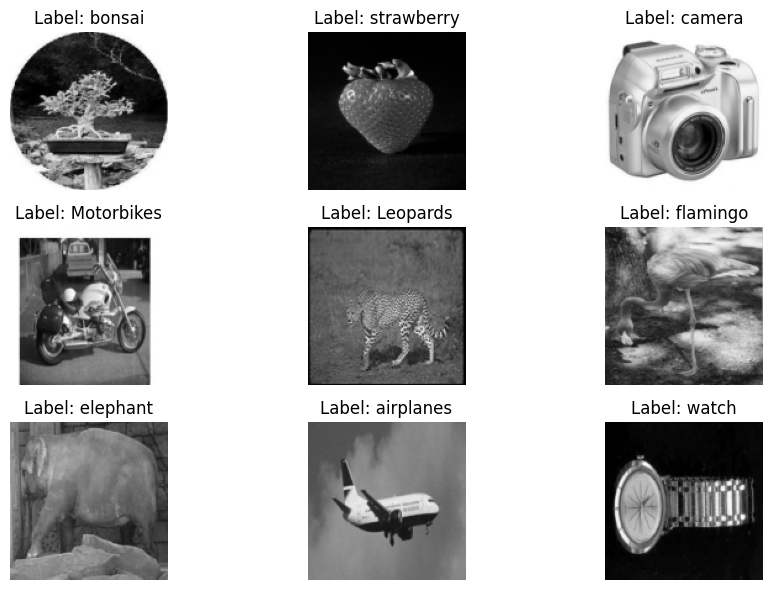

In [13]:
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n + 1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())

    # Use 'categories' instead of 'classes'
    label_name = dataset.categories[labels[0]]
    plt.title('Label: ' + label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Import pretrained VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]


In [15]:
# Change the output in the last layer to 101 classes
VGG16.classifier._modules['6'] = nn.Linear(4096, 101)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
VGG16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        sum_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # return the accuracy and loss
    return sum_correct/total, running_loss


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

In [19]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16.parameters(), lr=0.0001)

In [20]:
# total number of training epochs
epoch_num = 15

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

import datetime
now = datetime.datetime.now
t = now()

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(VGG16, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(VGG16, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

print('Training time: %s' % (now() - t))

Epoch: 1/15	 Training loss: 198.788	 Training accuracy: 58.724	 Validation accuracy: 82.699
Epoch: 2/15	 Training loss: 53.850	 Training accuracy: 86.587	 Validation accuracy: 86.621
Epoch: 3/15	 Training loss: 23.712	 Training accuracy: 93.560	 Validation accuracy: 89.389
Epoch: 4/15	 Training loss: 16.422	 Training accuracy: 95.447	 Validation accuracy: 87.543
Epoch: 5/15	 Training loss: 10.151	 Training accuracy: 97.133	 Validation accuracy: 89.965
Epoch: 6/15	 Training loss: 7.158	 Training accuracy: 98.098	 Validation accuracy: 90.196
Epoch: 7/15	 Training loss: 5.233	 Training accuracy: 98.646	 Validation accuracy: 90.311
Epoch: 8/15	 Training loss: 8.454	 Training accuracy: 97.796	 Validation accuracy: 90.888
Epoch: 9/15	 Training loss: 6.020	 Training accuracy: 98.286	 Validation accuracy: 90.427
Epoch: 10/15	 Training loss: 5.954	 Training accuracy: 98.502	 Validation accuracy: 91.003
Epoch: 11/15	 Training loss: 3.966	 Training accuracy: 98.977	 Validation accuracy: 91.003
Ep

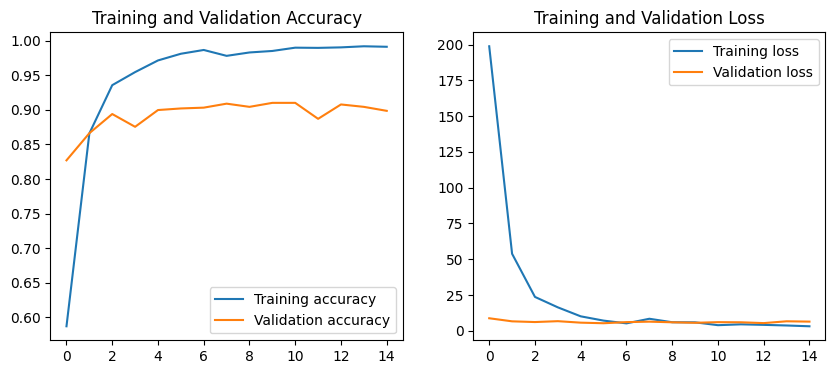

In [21]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 90.679


In [30]:
print(f"Train Accuracy: {training_accuracy_plot[-1] * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_plot[-1] * 100:.2f}%")

Train Accuracy: 99.11%
Validation Accuracy: 89.85%


In [23]:
epsilons = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

In [24]:
# FSGM
correct = 0
total = 0
accuracies_FSGM =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FSGM.append(np.mean(accuracy))
print(accuracies_FSGM)

0.0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.873046875, 0.8156311183009789, 0.7245334342963654, 0.6454573877427794, 0.5817279127013554, 0.5218476204881044, 0.4577716826963651, 0.4023410994782369]


In [25]:
# PGD
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter=60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0.0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.873046875, 0.7515232306891715, 0.567563313705555, 0.43931673121055653, 0.36303402700531456, 0.30845432627871266, 0.2658422661463338, 0.23186327117556427]


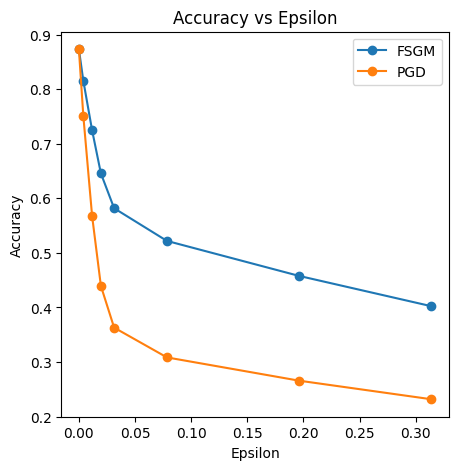

In [26]:
# FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")

plt.legend(['FSGM', 'PGD'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<ipython-input-27-5dea6adda688>:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


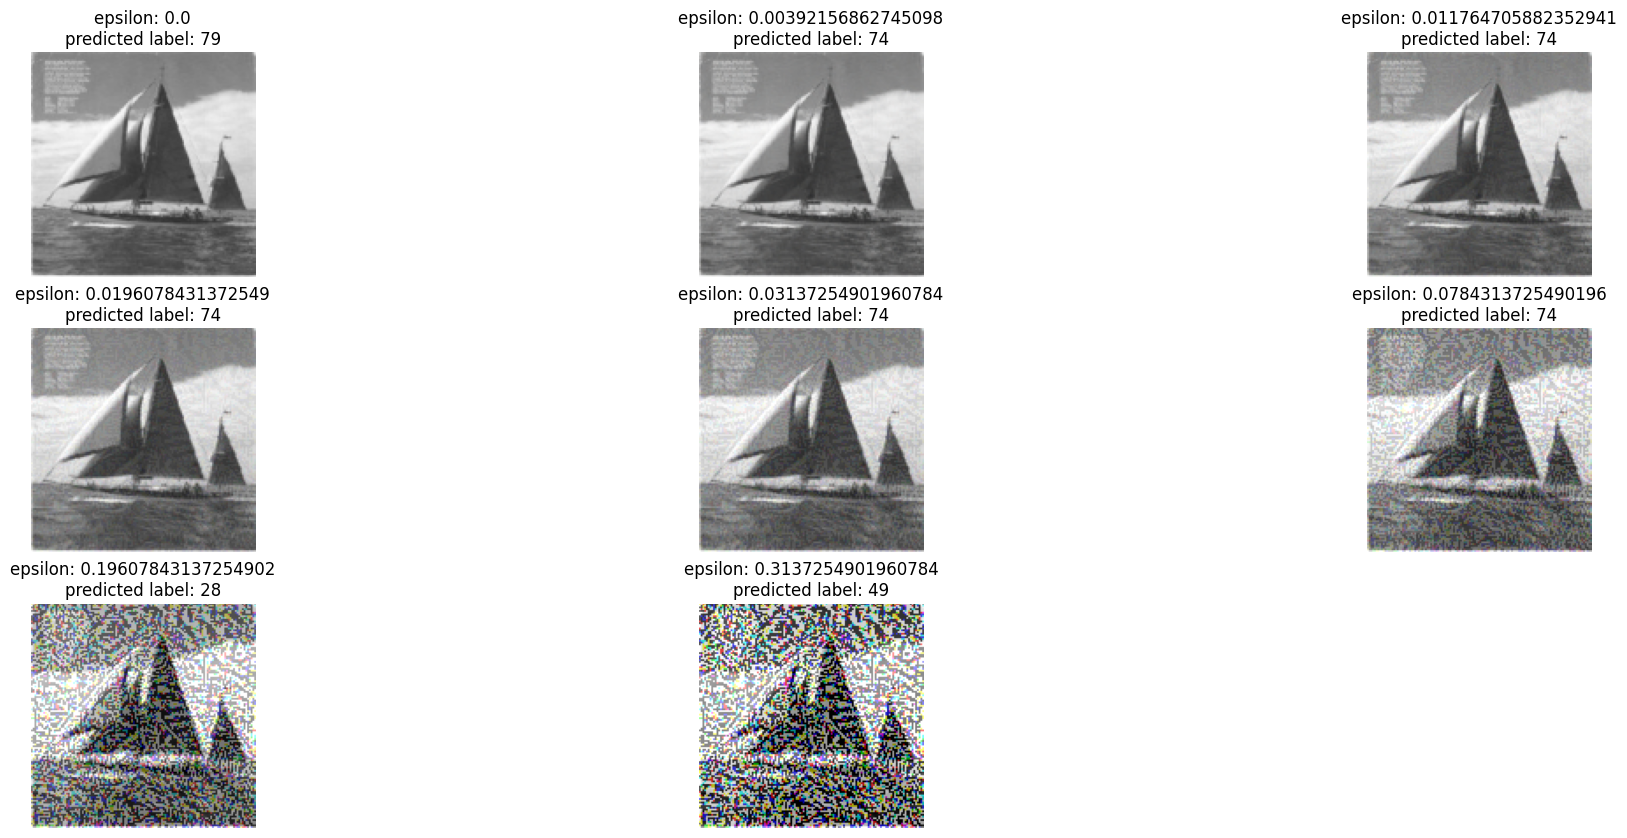

In [27]:
# FGSM - image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str(label))

    plt.axis('off')
    cnt +=1
  break

In [29]:
"""Carlini-Wagner L2 Attack with Evaluation on First 10 Test Images"""
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

INF = float("inf")

def carlini_wagner_l2(
    model_fn,
    x,
    n_classes,
    y=None,
    targeted=False,
    lr=5e-3,
    confidence=0,
    clip_min=0,
    clip_max=1,
    initial_const=1e-2,
    binary_search_steps=5,
    max_iterations=1000,
):
    """
    Implements the Carlini & Wagner L2 attack with improved loss computation and evaluation.
    """

    def compare(pred_logits, label):
        pred_label = torch.argmax(pred_logits).item()
        return pred_label == label.item() if targeted else pred_label != label.item()

    if y is None:
        y = torch.argmax(model_fn(x), dim=1)

    x = torch.clamp((x - clip_min) / (clip_max - clip_min), 0, 1)
    x_atanh = torch.atanh((x * 2 - 1) * 0.999999)

    lower_bound = torch.zeros(x.size(0), device=x.device)
    upper_bound = torch.full((x.size(0),), 1e10, device=x.device)
    const = torch.full((x.size(0),), initial_const, device=x.device)

    o_bestl2 = torch.full((x.size(0),), INF, device=x.device)
    o_bestattack = x.clone().detach()

    y_onehot = F.one_hot(y, n_classes).float()

    for _ in range(binary_search_steps):
        modifier = torch.zeros_like(x_atanh, requires_grad=True)
        optimizer = torch.optim.Adam([modifier], lr=lr)

        for _ in range(max_iterations):
            adv_x = torch.tanh(x_atanh + modifier) * 0.5 + 0.5
            logits = model_fn(adv_x)

            real = torch.sum(y_onehot * logits, dim=1)
            other = torch.max((1 - y_onehot) * logits - (y_onehot * 1e4), dim=1).values

            f = torch.clamp(
                (other - real + confidence) if targeted else (real - other + confidence), min=0
            )

            l2 = torch.sum((adv_x - (torch.tanh(x_atanh) * 0.5 + 0.5)) ** 2, dim=(1, 2, 3))
            loss = torch.sum(const * f + l2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for i in range(x.size(0)):
                if f[i] == 0 and l2[i] < o_bestl2[i]:
                    o_bestl2[i] = l2[i]
                    o_bestattack[i] = adv_x[i].detach()

    return torch.clamp(o_bestattack, clip_min, clip_max), o_bestl2

if __name__ == "__main__":
    # Example setup with dummy data; replace with real test loader and model
    class DummyModel(torch.nn.Module):
        def forward(self, x):
            return torch.randn(x.size(0), 10, device=x.device)  # Mock logits

    model = DummyModel().eval()
    test_images = torch.clamp(torch.randn(10, 3, 32, 32), 0, 1)
    true_labels = torch.randint(0, 10, (10,))

    # Untargeted attack
    adv_images, perturbations = carlini_wagner_l2(model, test_images, 10, true_labels, targeted=False)
    preds = torch.argmax(model(adv_images), dim=1)

    accuracy = (preds == true_labels).float().mean().item() * 100
    avg_perturbation = torch.sqrt(perturbations).mean().item()

    print(f"Untargeted attack predictions: {preds}")
    print(f"Accuracy after attack on 10 images: {accuracy:.2f}%")
    print(f"Average L2 perturbation: {avg_perturbation:.4f}")

    # Targeted attack example (random target labels different from true labels)
    target_labels = (true_labels + torch.randint(1, 10, (10,))) % 10
    adv_images_targeted, perturbations_targeted = carlini_wagner_l2(model, test_images, 10, target_labels, targeted=True)
    preds_targeted = torch.argmax(model(adv_images_targeted), dim=1)

    accuracy_targeted = (preds_targeted == target_labels).float().mean().item() * 100
    avg_perturbation_targeted = torch.sqrt(perturbations_targeted).mean().item()

    print(f"Targeted attack predictions: {preds_targeted}")
    print(f"Accuracy for targeted attack: {accuracy_targeted:.2f}%")
    print(f"Average L2 perturbation (targeted): {avg_perturbation_targeted:.4f}")


Untargeted attack predictions: tensor([5, 8, 7, 7, 3, 0, 2, 1, 0, 2])
Accuracy after attack on 10 images: 0.00%
Average L2 perturbation: 0.0000
Targeted attack predictions: tensor([0, 8, 6, 0, 7, 2, 3, 1, 7, 3])
Accuracy for targeted attack: 10.00%
Average L2 perturbation (targeted): 0.0000
